In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from datetime import datetime
from sqlalchemy import func

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [6]:
session = Session(engine)

In [7]:
precip_data = session.query(Measurements).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x199ce79c6d8>,
 'date': datetime.date(2010, 1, 1),
 'meas_id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [8]:
most_current = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = most_current[0]
year_before = last_date.replace(year = (last_date.year - 1))
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [9]:
twelve_months = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > year_before)
twelve_months_prcp = pd.read_sql_query(twelve_months.statement, engine, index_col = 'date')

In [10]:
twelve_months_prcp.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


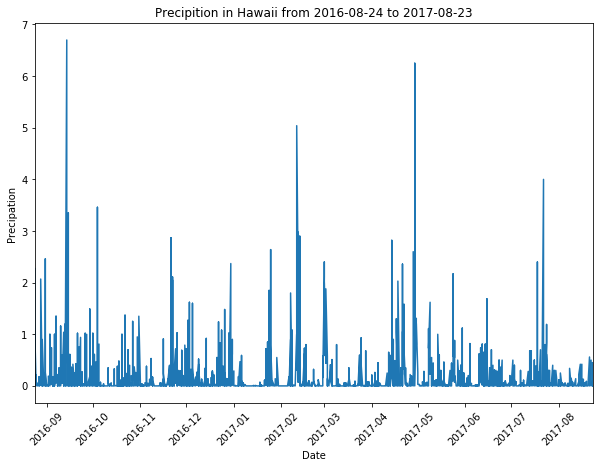

In [11]:
twelve_months_prcp.plot(figsize = (10,7), rot = 45, use_index = True, legend=False)
plt.ylabel('Precipation')
plt.xlabel('Date')
plt.title("Precipition in Hawaii from %s to %s" % (twelve_months_prcp.index.min(),twelve_months_prcp.index.max()))
plt.show()

In [12]:
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x199ce7b4400>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [13]:
num_stations = session.query(Stations.station).group_by(Stations.station).count()

In [14]:
num_stations

9

In [15]:
activity = session.query(Stations.station, Stations.name, Measurements.station, func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()

In [16]:
activity

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [17]:

max_activity = activity[0][0:2]
max_activity

('USC00519281', 'WAIHEE 837.5, HI US')

In [18]:
temps_maxact = session.query(Measurements.station, Measurements.tobs).filter(Measurements.station == max_activity[0], Measurements.date > year_before).all()

In [19]:
len(temps_maxact)

351

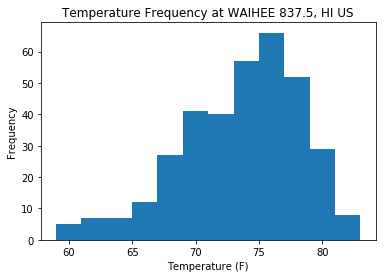

In [20]:
temps = [x[1] for x in temps_maxact]
plt.hist(temps, bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))
plt.show()

In [21]:
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurements.tobs).filter(Measurements.date >= new_dates[0], Measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(2,5))
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()

['2017-08-01', '2017-08-14']


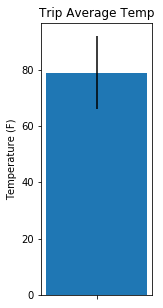

In [22]:
calc_temps('2018-08-01', '2018-08-14')

In [23]:
def daily_normals(chosen_date):
    temps = session.query(Measurements.tobs).filter(Measurements.date.like('%'+chosen_date)).all()
    obs = [x for (x), in temps]
    return obs
    
start_date = '08-23'
end_date = '09-04'

def create_date_list(start_date, end_date):
    start_month = start_date.split("-")[0]
    end_month = end_date.split("-")[0]
    
    start_day = int(start_date.split("-")[1])
    end_day = int(end_date.split("-")[1])
    
    if start_month == end_month:
        diff = end_day - start_day
        days = [start_day + x for x in range(0,diff + 1) ]
    
    else:
        diff1 = 31 - start_day
        days1 = [start_day + x for x in range(0,diff1 + 1)]
        days2 = [x for x in range(1, end_day + 1)]
        days = days1 + days2
        
    days_str = [('%s-%s' % (start_month, str(x))) if len(str(x)) == 2 else ('%s-0%s' % (end_month, str(x))) for x in days]
    return days_str

def query_results(start, end):
    dates = create_date_list(start, end)
    master_dict = {"Date": [], "Max Temp": [], "Min Temp": [], "Average Temp": []}
    for date in dates:
        data_list = []
        observations = daily_normals(date)
        if observations != []:
            for temp in observations:
                data_list.append(temp)
            master_dict['Date'].append(date)
            master_dict['Max Temp'].append(max(data_list))
            master_dict['Min Temp'].append(min(data_list))
            master_dict['Average Temp'].append(round(np.mean(data_list),2))
            master_dict
    return(master_dict)
    
normals_df = pd.DataFrame(query_results('08-01', '08-14')).set_index('Date')
normals_df

,Average Temp,Max Temp,Min Temp
Date,,,
08-01,75.54,83.0,67.0
08-02,75.60,84.0,68.0
08-03,76.61,85.0,70.0
08-04,76.71,84.0,69.0
08-05,76.15,82.0,69.0
08-06,76.25,83.0,67.0
08-07,77.16,83.0,71.0
08-08,76.56,83.0,68.0
08-09,75.98,81.0,69.0


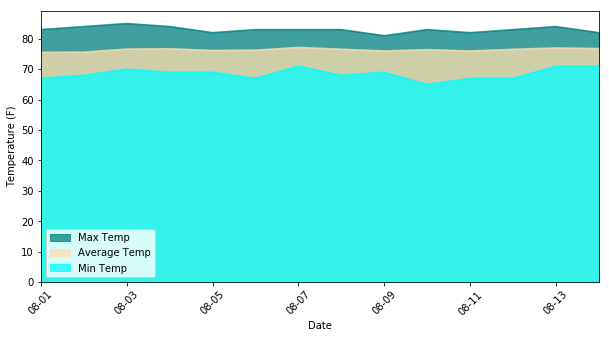

In [24]:
normals_df = normals_df[['Max Temp', 'Average Temp', 'Min Temp']]

normals_df.plot(kind = 'area', stacked = False, alpha = .75, rot = 45, color = ['teal', 'navajowhite', 'aqua'], figsize = (10,5), linestyle = 'solid')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(frameon = True)
plt.show()